# Check data from hubs

This notebook is different than usual - it includes the regular tests, but also includes RSSI data collected by a badge running the rssi_scanner

I had two sets of badges:
older batch:
* FD:99:D9:69:5D:BC 128 Badge 128, KL8TQM96BU
* EC:8F:47:27:6C:DE 129 Badge 129, NYCXUTEWZQ
* E5:3B:3A:53:DF:6C 130 Badge 130, 64XPCHHYXP
* DC:94:C8:A9:D0:B6 131 Badge 131, IAE2J5DVPX
* CB:3C:59:5F:87:FB 132 Badge 132, A3Q6U212Z7
* E9:0D:4A:6D:31:59 133 Badge 133, JGW5BXAIXM

newer batch:
* F1:4E:55:EA:ED:A4 210 Badge 210, 6GQQJ6EJLR
* E8:FA:0D:3C:01:82 211 Badge 211, FHB8ZFX0F8
* C2:57:36:E6:71:6E 212 Badge 212, CR267VPGRC
* D9:86:6F:AF:E8:90 213 Badge 213, 2SU8SEKOYH
* C1:96:24:5B:EB:97 214 Badge 214, HWEC31LUOJ
* C8:2F:80:DA:26:94 215 Badge 215, FF4GO085JA

In [1]:
from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np

import pytz
import gzip

# Import the data analysis tools
import openbadge_analysis as ob
import openbadge_analysis.preprocessing
import openbadge_analysis.core

In [2]:
# Settings
time_zone = 'US/Eastern' # Your local timezone
hublog_time_zone = 'UTC'
log_version = '2.0'
time_bins_size = '60S' # For proximity scans

folder = '../data/raw/20180326_rssi_voltage_test/'
proximity_filename = folder+'proximity_archive.txt.gz'
audio_filename = folder+'audio_archive.txt.gz'
hublog_filename = folder+'hub.log.gz'

In [3]:
# enables the %%R magic, not necessary if you've already done this
import readline
%load_ext rpy2.ipython 

%R -i time_zone timezone <- time_zone; print(timezone)

[1] "US/Eastern"


In [4]:
%%R
library(ggplot2)
library(scales)
rh_theme = theme(
    legend.title=element_text(size=2) , 
    legend.text=element_text(size=2)
    #panel.background=element_rect(fill="white"), # background=white
    #panel.grid.major.x=element_blank(), #no gridlines
    #panel.grid.minor.x=element_blank(), 
    #panel.grid.major.y=element_blank(), 
    #panel.grid.minor.y=element_blank(),
    #axis.text.x = element_text(angle=90, hjust = 1,vjust=1,size = 4,face = "bold"),
    #axis.text.y = element_text(size = 4)
)

# Load data

In [5]:
print("Loading sample counts for proximity")
with gzip.open(proximity_filename, 'r') as f:
    proximity_sample_counts = ob.preprocessing.sample_counts(f, tz=time_zone)

print("Loading sample counts for audio")
with gzip.open(audio_filename, 'r') as f:
    audio_sample_counts = ob.preprocessing.sample_counts(f, tz=time_zone)
    
print("Loading reset data")
with gzip.open(hublog_filename, 'r') as f:
    resets = ob.preprocessing.hublog_resets(f, log_tz = hublog_time_zone, tz=time_zone)

print("Loading voltage data (from proximity records)")
with gzip.open(proximity_filename, 'r') as f:
    voltages = ob.preprocessing.voltages(f, time_bins_size, tz=time_zone)

print("Loading clock sync data")
with gzip.open(hublog_filename, 'r') as f:
    clock_syncs = ob.preprocessing.hublog_clock_syncs(f, log_tz = hublog_time_zone, tz=time_zone)

Loading sample counts for proximity
Loading sample counts for audio
Loading reset data
Loading voltage data (from proximity records)
Loading clock sync data


In [6]:
# starting time
first_date = resets.index.get_level_values('datetime').min()
first_date

Timestamp('2018-03-26 20:53:47.389000-0400', tz='US/Eastern')

In [7]:
def to_relative_datetime(data):
    """ switch to relative time (since experiment started) """
    realtive_time = data.reset_index().copy()
    realtive_time['datetime'] = realtive_time['datetime'] - first_date
    realtive_time['day'] = realtive_time['datetime']/pd.Timedelta(days=1)
    return realtive_time

# Cleanup
Sometimes we get some records from the future or past. It's a bug, but it's so uncommon that we haven't found the reason yet


In [8]:
time_slice = slice('2018-01-01 00:00:00', '2019-01-01 00:00:00')

resets = resets.loc[time_slice, :]
voltages = voltages.loc[time_slice, :]

proximity_sample_counts.reset_index(level=1,inplace=True)
proximity_sample_counts = proximity_sample_counts.loc[time_slice, :]
proximity_sample_counts.set_index('member', append=True, inplace=True)

audio_sample_counts.reset_index(level=1,inplace=True)
audio_sample_counts = audio_sample_counts.loc[time_slice, :]
audio_sample_counts.set_index('member', append=True, inplace=True)

clock_syncs = clock_syncs.loc[time_slice, :]

# Voltage
Here we simply show the voltages of all the badges in the test. This helps us check how long they run and how fast the battery is deplated.

In [9]:
# Down sample
voltages_down = voltages.groupby([pd.TimeGrouper('300S', level='datetime'), 'member']).mean()

In [10]:
# Relative time
voltages_realtive_time = to_relative_datetime(voltages_down)

In [11]:
print(voltages_realtive_time.dtypes)
voltages_realtive_time.head()

datetime    timedelta64[ns]
member               object
voltage             float64
day                 float64
dtype: object


,datetime,member,voltage,day
0,-1 days +23:56:12.611000,6GQQJ6EJLR,2.990,-0.002632
1,-1 days +23:56:12.611000,CR267VPGRC,2.970,-0.002632
2,-1 days +23:56:12.611000,FHB8ZFX0F8,3.010,-0.002632
3,-1 days +23:56:12.611000,KL8TQM96BU,2.940,-0.002632
4,00:01:12.611000,2SU8SEKOYH,2.972,0.000840


/home/orenled/.virtualenvs/openbadge-analysis-test-badge/local/lib/python2.7/site-packages/rpy2/robjects/pandas2ri.py:57: UserWarning: Error while trying to convert the column "datetime". Fall back to string conversion. The error is: Unknown numpy array type 'timedelta64[ns]'.
  (name, str(e)))


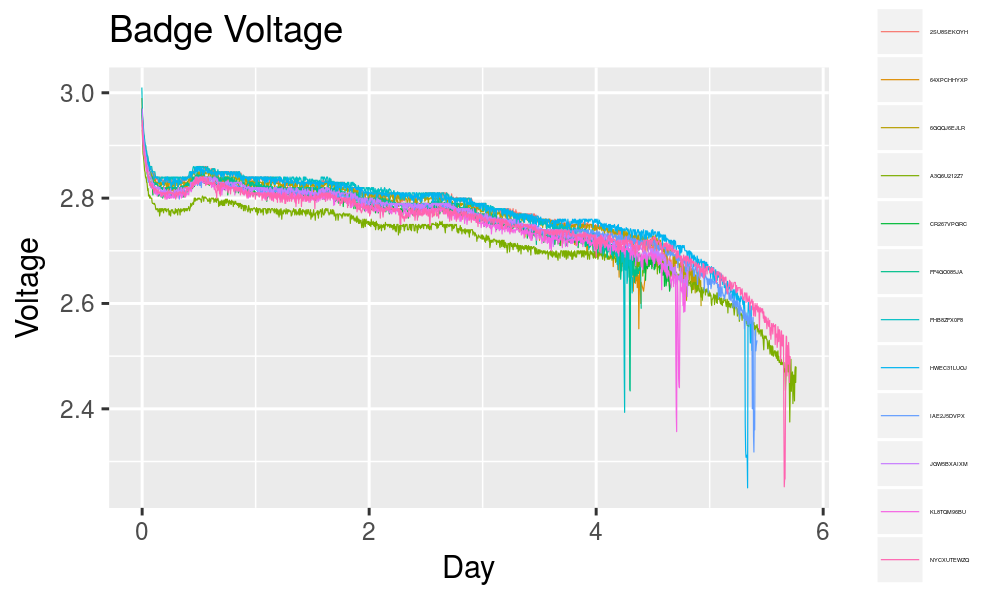

In [12]:
%%R -i voltages_realtive_time -w 5 -h 3 --units in -r 200
data <- voltages_realtive_time
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = voltage, color =member)) +
    geom_line(size=0.2) +
    labs(title="Badge Voltage", x="Day", y="Voltage") +
    rh_theme

# Resets
Here we look at "reset events" - when the hub sends the date the a badge, and the badge did not have a date set already. This means that the badge was either just turned on, or was reset. We expect to see a reset when the badge was first turned on, and we don't expect to see any resest until the voltages drop below 2.4v or so

In [13]:
resets_down = resets.copy()
resets_down['cnt'] = 1
resets_down = resets_down.groupby([pd.TimeGrouper('30min', level='datetime'), 'mac']).count()
resets_down.head(1)

,,cnt
datetime,mac,
2018-03-26 20:30:00-04:00,C1:96:24:5B:EB:97,1


In [14]:
# switch to relative time (since experiment started)
resets_realtive_time = to_relative_datetime(resets_down)
resets_realtive_time.head()

,datetime,mac,cnt,day
0,-1 days +23:36:12.611000,C1:96:24:5B:EB:97,1,-0.016521
1,-1 days +23:36:12.611000,C2:57:36:E6:71:6E,1,-0.016521
2,-1 days +23:36:12.611000,C8:2F:80:DA:26:94,1,-0.016521
3,-1 days +23:36:12.611000,CB:3C:59:5F:87:FB,1,-0.016521
4,-1 days +23:36:12.611000,D9:86:6F:AF:E8:90,1,-0.016521


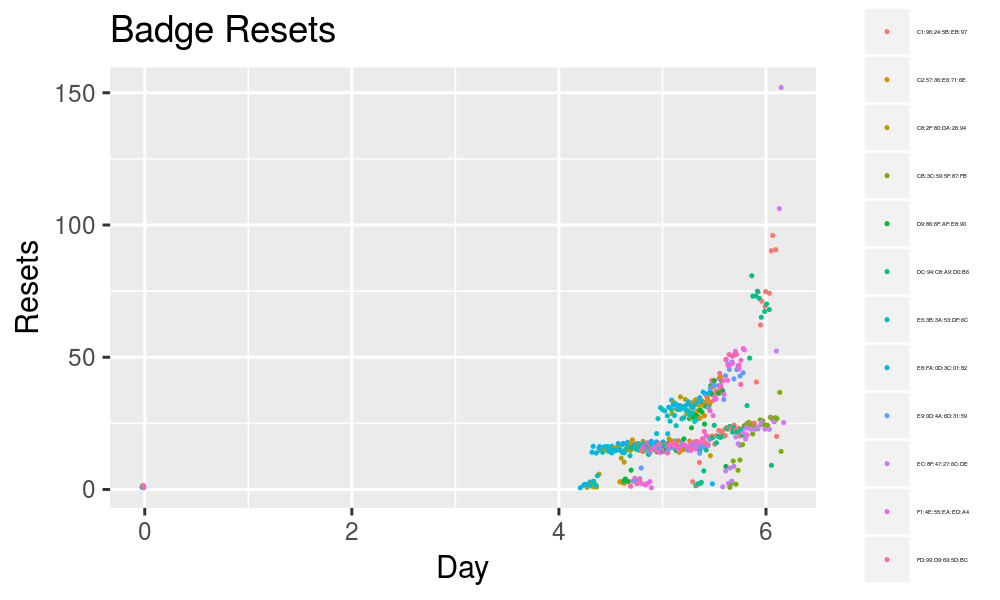

In [15]:
%%R -i resets_realtive_time -w 5 -h 3 --units in -r 200
data <- resets_realtive_time
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = cnt, color = mac)) +
    geom_point(size=0.2, position = "jitter") +
    labs(title="Badge Resets", x="Day", y="Resets") +
    rh_theme

# First resets
The first time a badge was reset (after starting)

In [16]:
df = pd.DataFrame([[1, np.nan], [1, 4], [5, 6]], columns=['A', 'B'])
g = df.groupby('A').nth(0)
df

,A,B
0,1,NaN
1,1,4.0
2,5,6.0


In [17]:
first_reset = resets.copy().reset_index()
first_reset = first_reset.groupby('mac').nth(2)

In [18]:
# switch to relative time (since experiment started)
first_reset_realtive_time = to_relative_datetime(first_reset)
first_reset_realtive_time.head()

,mac,datetime,day
0,C1:96:24:5B:EB:97,5 days 07:20:10.293000,5.305675
1,C2:57:36:E6:71:6E,4 days 14:16:31.637000,4.594811
2,C8:2F:80:DA:26:94,4 days 07:07:57.606000,4.297195
3,CB:3C:59:5F:87:FB,5 days 16:09:10.907000,5.673043
4,D9:86:6F:AF:E8:90,4 days 15:16:36.930000,4.636539


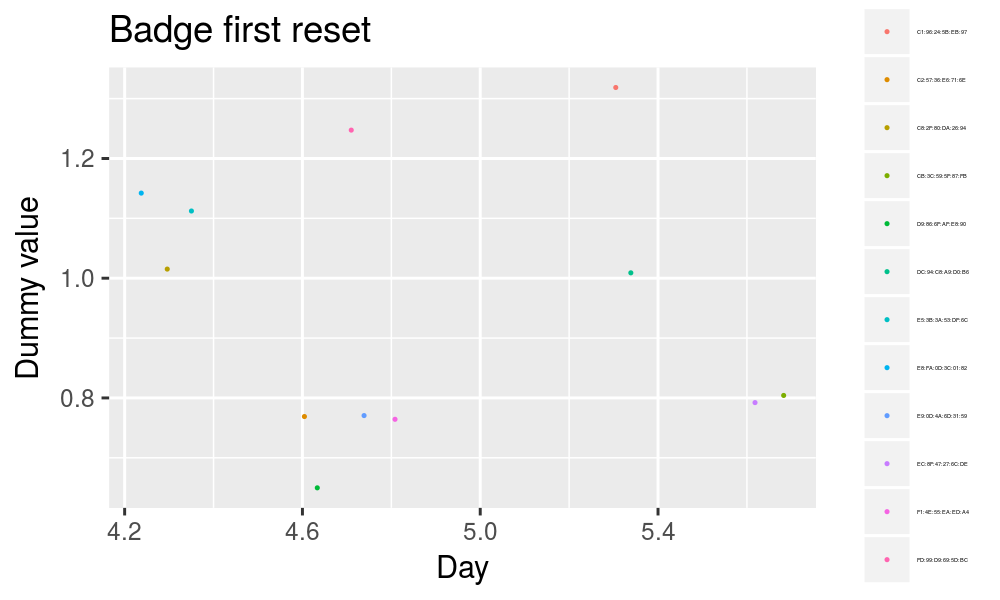

In [19]:
%%R -i first_reset_realtive_time -w 5 -h 3 --units in -r 200
data <- first_reset_realtive_time
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = 1, color = mac)) +
    geom_point(size=0.2, position = "jitter") +
    labs(title="Badge first reset", x="Day", y="Dummy value") +
    rh_theme

# Proximity sample counts

In [20]:
# Down sample
proximity_sample_counts_down = proximity_sample_counts.copy()
proximity_sample_counts_down = proximity_sample_counts_down.groupby([pd.TimeGrouper('30min', level='datetime'), 'member']).mean()
proximity_sample_counts_down.head(1)

# switch to relative time (since experiment started)
proximity_sample_counts_realtive_time = to_relative_datetime(proximity_sample_counts_down)
proximity_sample_counts_realtive_time.head()

,datetime,member,cnt,day
0,-1 days +23:36:12.611000,2SU8SEKOYH,14.0,-0.016521
1,-1 days +23:36:12.611000,64XPCHHYXP,13.6,-0.016521
2,-1 days +23:36:12.611000,6GQQJ6EJLR,14.0,-0.016521
3,-1 days +23:36:12.611000,A3Q6U212Z7,13.8,-0.016521
4,-1 days +23:36:12.611000,CR267VPGRC,14.0,-0.016521


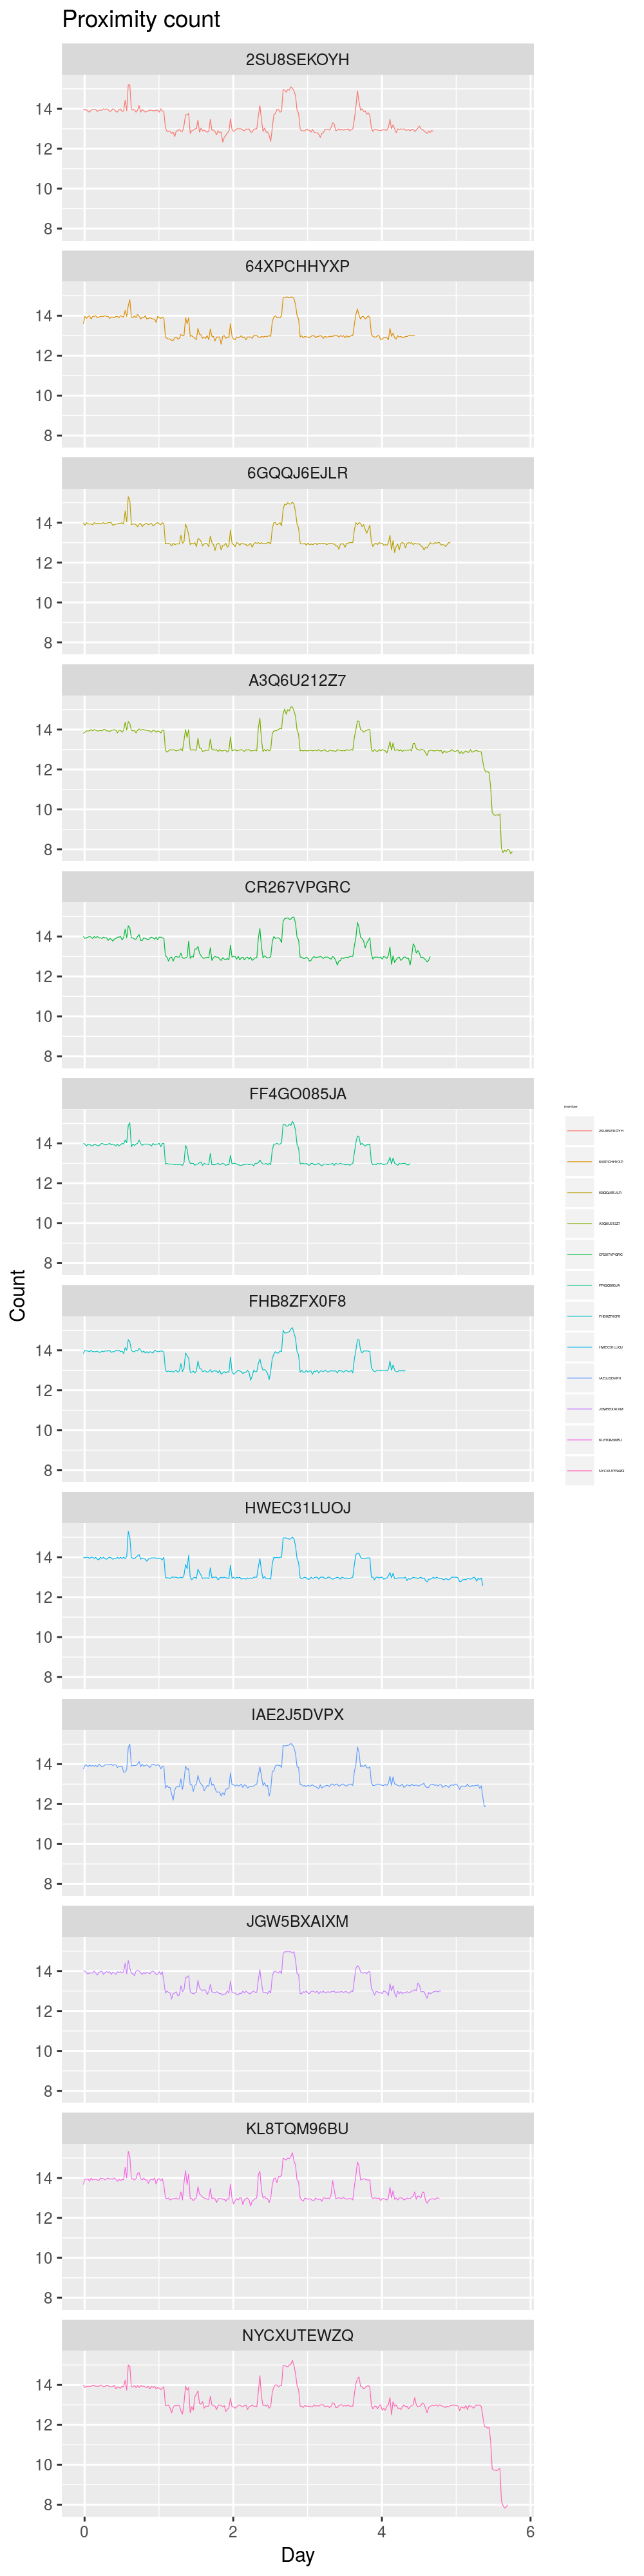

In [38]:
%%R -i proximity_sample_counts_realtive_time -w 5 -h 20 --units in -r 200
data <- proximity_sample_counts_realtive_time
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = cnt, color =member)) +
    geom_line(size=0.2) +
    facet_wrap( ~ member, ncol=1)+
    labs(title="Proximity count", x="Day", y="Count") +
    rh_theme

# Audio records count
For audio, we can't simply down sample. At least for the current version, we might get a "partial" record (less than 114 samples), and later the full version of the record. We'll therefore remove the duplications (using group by), and then resample and fill NaN with zeros in order to find gaps. We use a 10S window since every record represents 5.7 seconds of data, and we want to make sure not to create zero counts when there is no need to.

In [22]:
audio_sample_counts_down = audio_sample_counts.copy()

In [23]:
# Removing records so I can test what happens when there is missing data
#s = slice('2017-12-02 16:55:20', '2017-12-02 16:55:40')
#audio_sample_counts_down.drop(audio_sample_counts_down.loc[(s, slice(None), slice(None)), :].index, inplace=True)
#print(len(audio_sample_counts))
#print(len(audio_sample_counts_down))

In [24]:
# If there are duplicates, choose the record with the most samples (that's a complete record)
audio_sample_counts_down = audio_sample_counts_down.groupby(['datetime', 'member']).max()

# Put 0's if there is missing data
audio_sample_counts_down = audio_sample_counts_down.unstack(level=[1]).resample('10S').min().fillna(0).stack(level=[1])

In [25]:
# If removed records for testing, are there 0's there now?
#audio_counts_down.loc[(s, slice(None), slice(None)), :]

In [26]:
# Down sample
audio_sample_counts_down = audio_sample_counts_down.unstack(level=[1]).resample('1min').min().stack(level=[1])
audio_sample_counts_realtive_time = audio_sample_counts_down.reset_index()

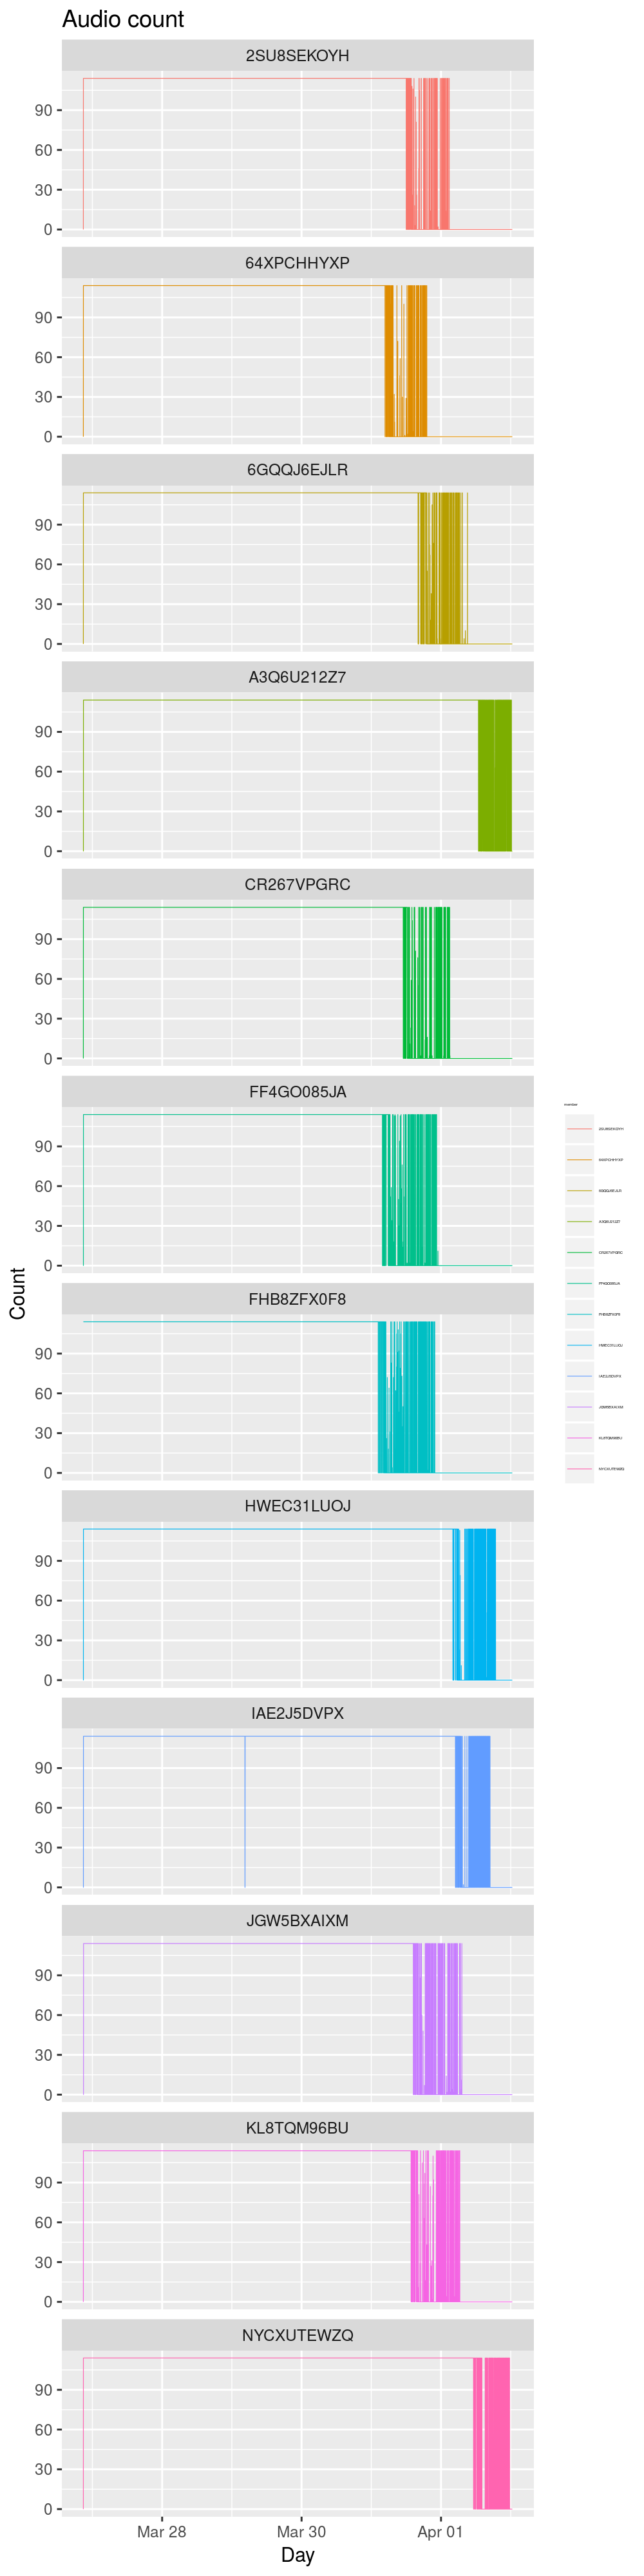

In [39]:
%%R -i audio_sample_counts_realtive_time -w 5 -h 20 --units in -r 200
data <- audio_sample_counts_realtive_time
data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = datetime, y = cnt, color = member)) +
    geom_line(size=0.2) +
    facet_wrap( ~ member, ncol=1)+
    labs(title="Audio count", x="Day", y="Count") +
    rh_theme

# Gaps in proximity data
Here we look for gaps in proximity data. We expect to see gaps of 60 seconds between scans (or less/more, depending on the settings used). If it's higher than that, then there's a gap.

In [28]:
proximity_sample_counts_shift = proximity_sample_counts.copy().reset_index()
proximity_sample_counts_shift['lag_datetime'] = proximity_sample_counts_shift.groupby(['member'])['datetime'].shift(1)
proximity_sample_counts_shift['lag_datetime'] = proximity_sample_counts_shift['lag_datetime'].dt.tz_localize('UTC').dt.tz_convert(time_zone)
proximity_sample_counts_shift['time_diff_sec']= (proximity_sample_counts_shift['datetime']-proximity_sample_counts_shift['lag_datetime']) / np.timedelta64(1, 's')

# Down sample
proximity_sample_counts_shift.set_index('datetime', inplace=True)
proximity_sample_counts_shift_down = proximity_sample_counts_shift.groupby([pd.TimeGrouper('30min', level='datetime'), 'member']).max()

# switch to relative time (since experiment started)
proximity_sample_counts_shift_realtive_time = to_relative_datetime(proximity_sample_counts_shift_down)
proximity_sample_counts_shift_realtive_time.head()

,datetime,member,cnt,lag_datetime,time_diff_sec,day
0,-1 days +23:36:12.611000,2SU8SEKOYH,14,2018-03-26 20:58:05-04:00,60.0,-0.016521
1,-1 days +23:36:12.611000,64XPCHHYXP,14,2018-03-26 20:58:02-04:00,60.0,-0.016521
2,-1 days +23:36:12.611000,6GQQJ6EJLR,14,2018-03-26 20:58:56-04:00,60.0,-0.016521
3,-1 days +23:36:12.611000,A3Q6U212Z7,14,2018-03-26 20:58:22-04:00,60.0,-0.016521
4,-1 days +23:36:12.611000,CR267VPGRC,14,2018-03-26 20:58:59-04:00,60.0,-0.016521


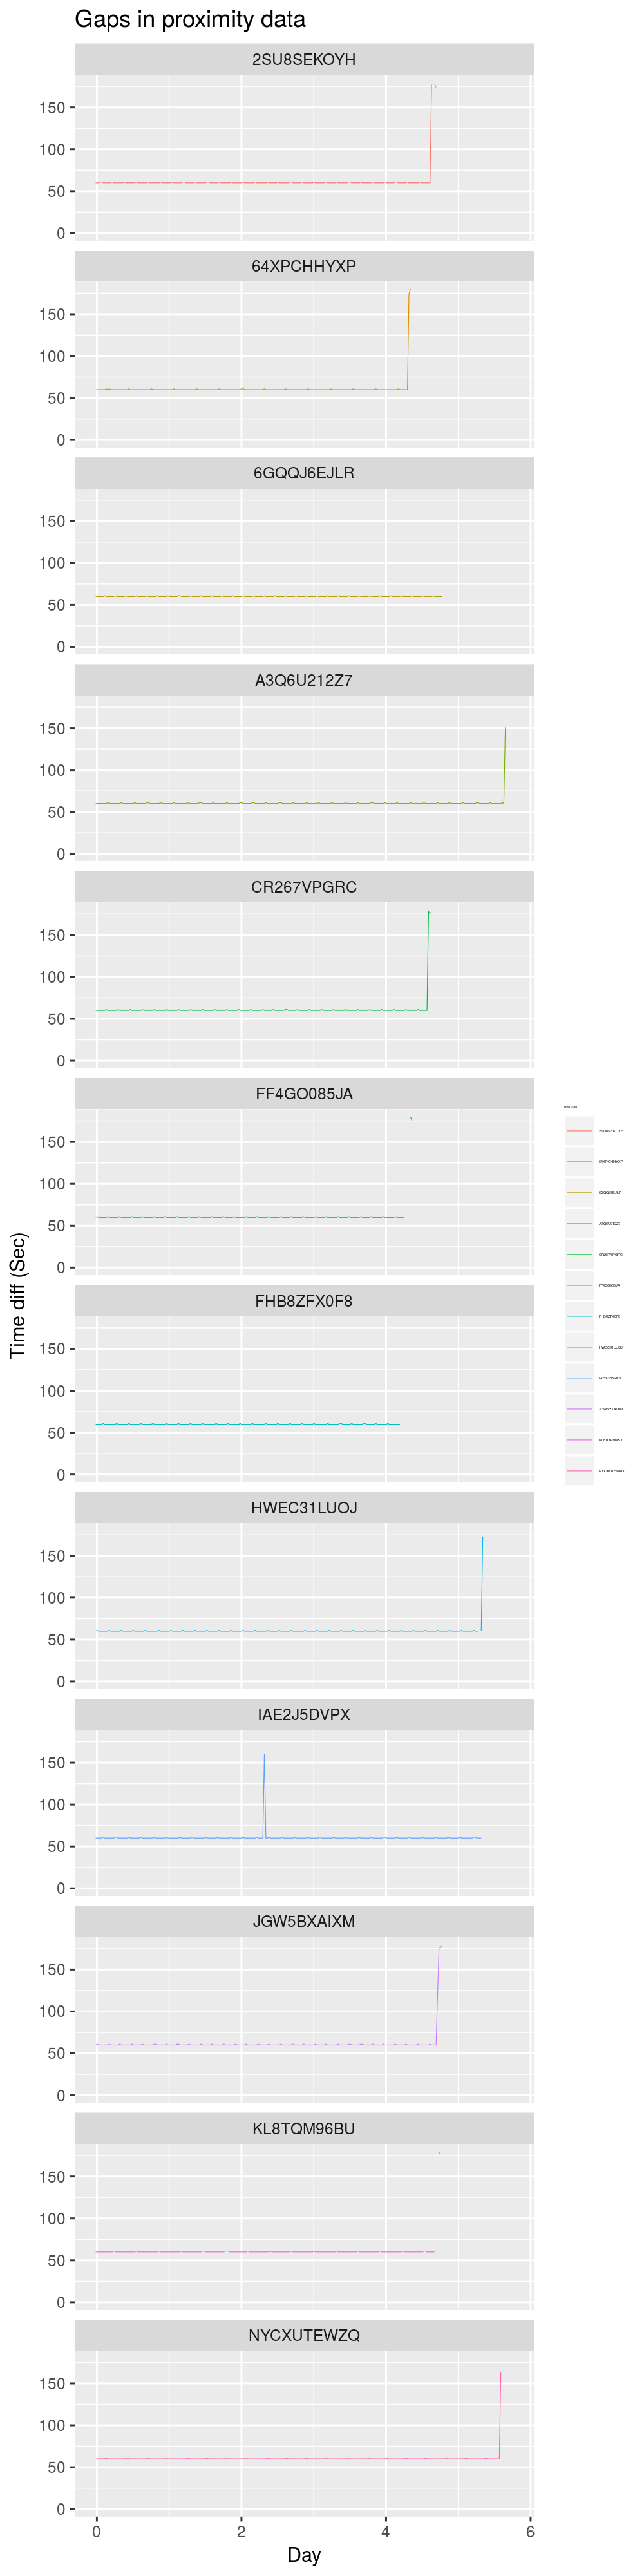

In [40]:
%%R -i proximity_sample_counts_shift_realtive_time -w 5 -h 20 --units in -r 200
data <- proximity_sample_counts_shift_realtive_time
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = time_diff_sec, color = member)) +
    geom_line(size=0.2) +
    facet_wrap( ~ member, ncol=1)+
    labs(title="Gaps in proximity data", x="Day", y="Time diff (Sec)") +
    scale_y_continuous(limits = c(0, 180)) +
    rh_theme

# Gaps in audio data
Here we look for gaps in audio data. We expect to see gaps of 5.7 seconds between records (each record represents 114 samples of 50 ms each). If it's higher than that, then there's a gap.

In [30]:
audio_sample_counts_shift = audio_sample_counts.copy().reset_index()
audio_sample_counts_shift['lag_datetime'] = audio_sample_counts_shift.groupby(['member'])['datetime'].shift(1)
audio_sample_counts_shift['lag_datetime'] = audio_sample_counts_shift['lag_datetime'].dt.tz_localize('UTC').dt.tz_convert(time_zone)
audio_sample_counts_shift['time_diff_sec']= (audio_sample_counts_shift['datetime']-audio_sample_counts_shift['lag_datetime']) / np.timedelta64(1, 's')

# Down sample
audio_sample_counts_shift.set_index('datetime', inplace=True)
audio_sample_counts_shift_down = audio_sample_counts_shift.groupby([pd.TimeGrouper('30min', level='datetime'), 'member']).max()

# switch to relative time (since experiment started)
audio_sample_counts_shift_realtive_time = to_relative_datetime(audio_sample_counts_shift_down)
audio_sample_counts_shift_realtive_time.head()

,datetime,member,cnt,lag_datetime,time_diff_sec,day
0,-1 days +23:36:12.611000,2SU8SEKOYH,114,2018-03-26 20:59:53.207000-04:00,5.703,-0.016521
1,-1 days +23:36:12.611000,64XPCHHYXP,114,2018-03-26 20:59:50.120000-04:00,5.703,-0.016521
2,-1 days +23:36:12.611000,6GQQJ6EJLR,114,2018-03-26 20:59:49.486000-04:00,5.704,-0.016521
3,-1 days +23:36:12.611000,A3Q6U212Z7,114,2018-03-26 20:59:52.588000-04:00,5.722,-0.016521
4,-1 days +23:36:12.611000,CR267VPGRC,114,2018-03-26 20:59:58.193000-04:00,5.706,-0.016521


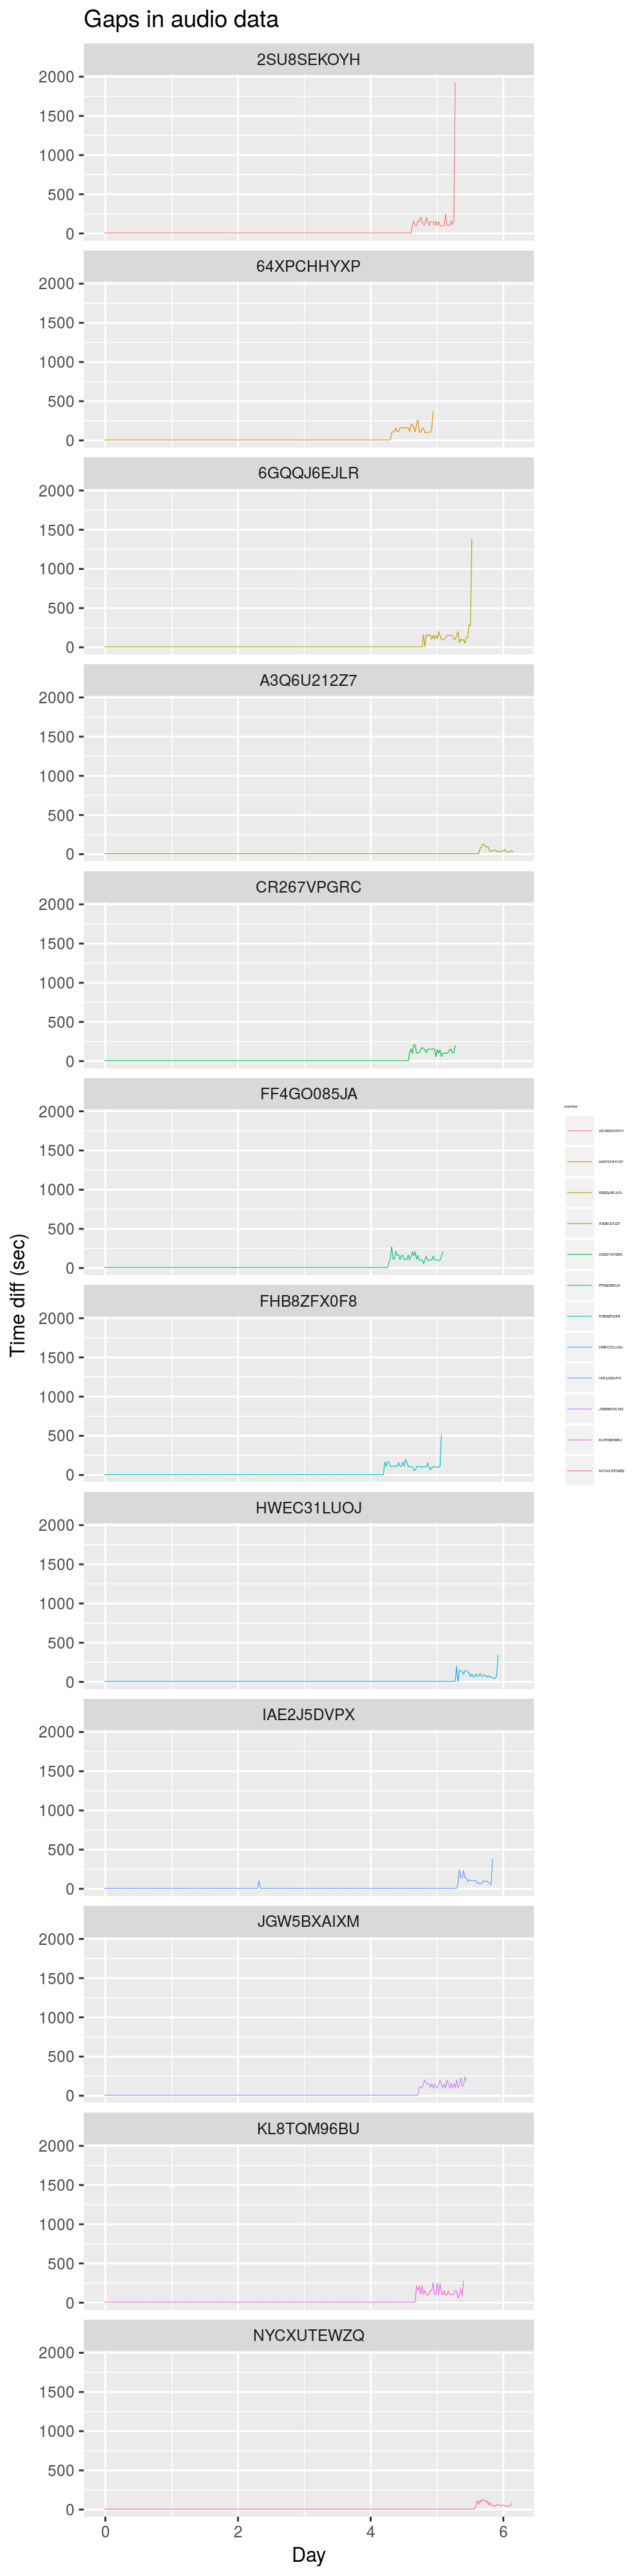

In [41]:
%%R -i audio_sample_counts_shift_realtive_time -w 5 -h 20 --units in -r 200
data <- audio_sample_counts_shift_realtive_time
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = time_diff_sec, color = member)) +
    geom_line(size=0.2) +
    facet_wrap( ~ member, ncol=1)+
    #scale_y_continuous(limits = c(0, 60)) +
    labs(title="Gaps in audio data", x="Day", y="Time diff (sec)") +
    rh_theme

# Comparing badge time to hub time
Here, we look at event where we send time from the hub to the badge. On each event, the badge reports back its internal time

In [32]:
clock_syncs.head()

,mac,badge_datetime
datetime,,
2018-03-26 20:53:47.432000-04:00,E8:FA:0D:3C:01:82,2018-03-26 20:53:47.390000-04:00
2018-03-26 20:53:53.230000-04:00,FD:99:D9:69:5D:BC,2018-03-26 20:53:53.188000-04:00
2018-03-26 20:53:56.229000-04:00,F1:4E:55:EA:ED:A4,2018-03-26 20:53:56.187000-04:00
2018-03-26 20:53:59.236000-04:00,C2:57:36:E6:71:6E,2018-03-26 20:53:59.195000-04:00
2018-03-26 20:54:02.574000-04:00,E5:3B:3A:53:DF:6C,2018-03-26 20:54:02.533000-04:00


In [33]:
# Down sample
clock_syncs_down = clock_syncs.copy().reset_index()
clock_syncs_down['clock_diff']=(clock_syncs_down['datetime']-clock_syncs_down['badge_datetime'])/pd.Timedelta(milliseconds=1)

clock_syncs_down.set_index(['datetime','mac'], inplace=True)
clock_syncs_down = clock_syncs_down.groupby([pd.TimeGrouper('30min', level='datetime'), 'mac'])['clock_diff'].max().to_frame()
clock_syncs_down.reset_index(inplace=True)

In [34]:
clock_syncs_down.head(5)

,datetime,mac,clock_diff
0,2018-03-26 20:30:00-04:00,C1:96:24:5B:EB:97,50.0
1,2018-03-26 20:30:00-04:00,C2:57:36:E6:71:6E,46.0
2,2018-03-26 20:30:00-04:00,C8:2F:80:DA:26:94,45.0
3,2018-03-26 20:30:00-04:00,CB:3C:59:5F:87:FB,63.0
4,2018-03-26 20:30:00-04:00,D9:86:6F:AF:E8:90,45.0


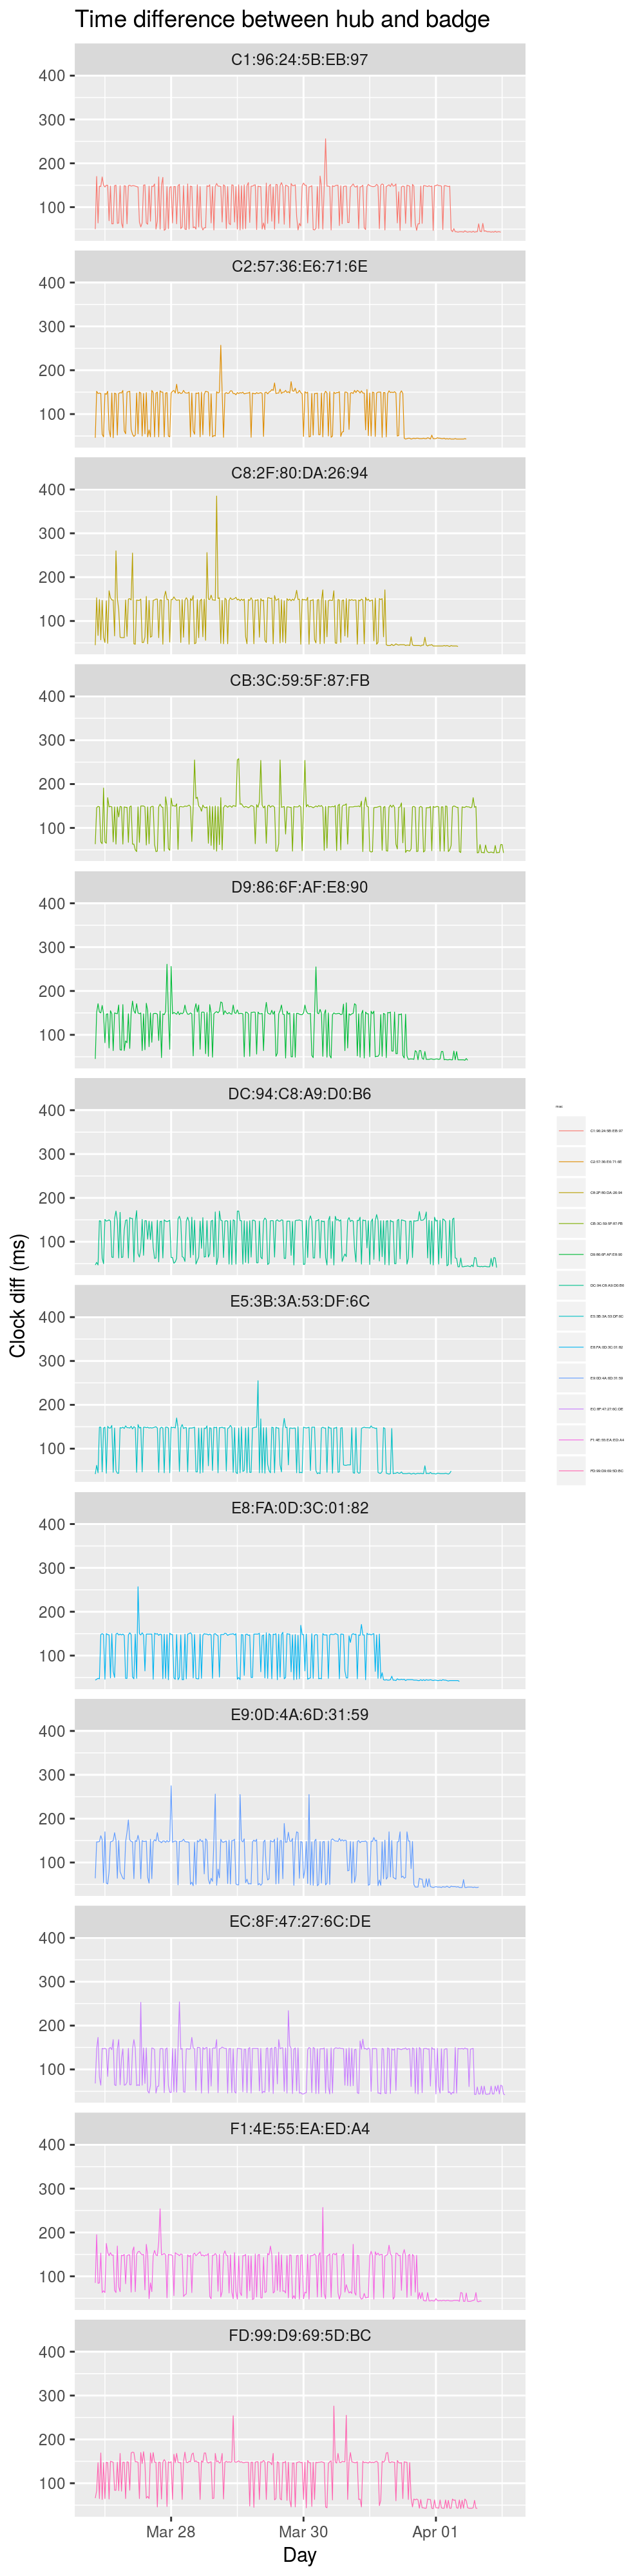

In [42]:
%%R -i clock_syncs_down -w 5 -h 20 --units in -r 200
data <- clock_syncs_down
data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = datetime, y = clock_diff, color = mac)) +
    geom_line(size=0.2) +
    facet_wrap( ~ mac, ncol=1)+
    labs(title="Time difference between hub and badge", x="Day", y="Clock diff (ms)") +
    rh_theme

# XX - testing RSSI

In [55]:
def scan_lines(fileobject, time_bins_size='1min', tz='US/Eastern'):
    
    df = pd.read_csv(f, names=['timestamp','mac','rssi'])

    # Convert the timestamp to a datetime, localized in UTC
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s', utc=True) \
                       .dt.tz_localize('UTC').dt.tz_convert(tz)
    del df['timestamp']

    #df.sort_index(inplace=True)
    
    return df

In [62]:
rssi_scanner_filename = folder + 'BLE_range_test.log.gz'
#rssi_scanner_filename = folder + '1.log.gz'
with gzip.open(rssi_scanner_filename, 'r') as f:
    skip_line = f.readline()
    skip_line = f.readline()
    rssi_scans = scan_lines(f)
    
badges_list = resets.mac.unique()
rssi_scans = rssi_scans[rssi_scans['mac'].isin(badges_list)]
rssi_scans.set_index('datetime','mac', inplace=True)

In [68]:
print(rssi_scans.head(5))
len(rssi_scans)

                                                mac  rssi
datetime                                                 
2018-03-26 20:52:23.089000-04:00  FD:99:D9:69:5D:BC -56.0
2018-03-26 20:52:23.092000-04:00  FD:99:D9:69:5D:BC -56.0
2018-03-26 20:52:23.096000-04:00  E9:0D:4A:6D:31:59 -66.0
2018-03-26 20:52:23.098000-04:00  EC:8F:47:27:6C:DE -51.0
2018-03-26 20:52:23.104000-04:00  C2:57:36:E6:71:6E -56.0


13027199

In [78]:
# Relative time
rssi_scans_realtive_time = to_relative_datetime(rssi_scans)
rssi_scans_realtive_time.set_index('datetime','mac', inplace=True)
rssi_scans_realtive_time.head(5)

,datetime,mac,rssi,day
0,-1 days +23:58:35.700000,FD:99:D9:69:5D:BC,-56.0,-0.000976
1,-1 days +23:58:35.703000,FD:99:D9:69:5D:BC,-56.0,-0.000976
2,-1 days +23:58:35.707000,E9:0D:4A:6D:31:59,-66.0,-0.000976
3,-1 days +23:58:35.709000,EC:8F:47:27:6C:DE,-51.0,-0.000976
4,-1 days +23:58:35.715000,C2:57:36:E6:71:6E,-56.0,-0.000976


In [81]:
rssi_scans_realtive_time.head(5)

,mac,rssi,day
datetime,,,
-1 days +23:58:35.700000,FD:99:D9:69:5D:BC,-56.0,-0.000976
-1 days +23:58:35.703000,FD:99:D9:69:5D:BC,-56.0,-0.000976
-1 days +23:58:35.707000,E9:0D:4A:6D:31:59,-66.0,-0.000976
-1 days +23:58:35.709000,EC:8F:47:27:6C:DE,-51.0,-0.000976
-1 days +23:58:35.715000,C2:57:36:E6:71:6E,-56.0,-0.000976


In [87]:
# downsample RSSI
rssi_scans_down = rssi_scans_realtive_time.groupby([pd.TimeGrouper('300S', level='datetime'), 'mac']).mean()
print(len(rssi_scans_down))
rssi_scans_down.head(5)

20004


rssi       day
datetime                 mac                                   
-1 days +23:58:35.700000 C1:96:24:5B:EB:97 -55.720827  0.000720
                         C2:57:36:E6:71:6E -54.936202  0.000666
                         C8:2F:80:DA:26:94 -52.357798  0.000745
                         CB:3C:59:5F:87:FB -59.176812  0.000712
                         D9:86:6F:AF:E8:90 -56.525122  0.000781

In [88]:
rssi_scans_down.reset_index(inplace=True)

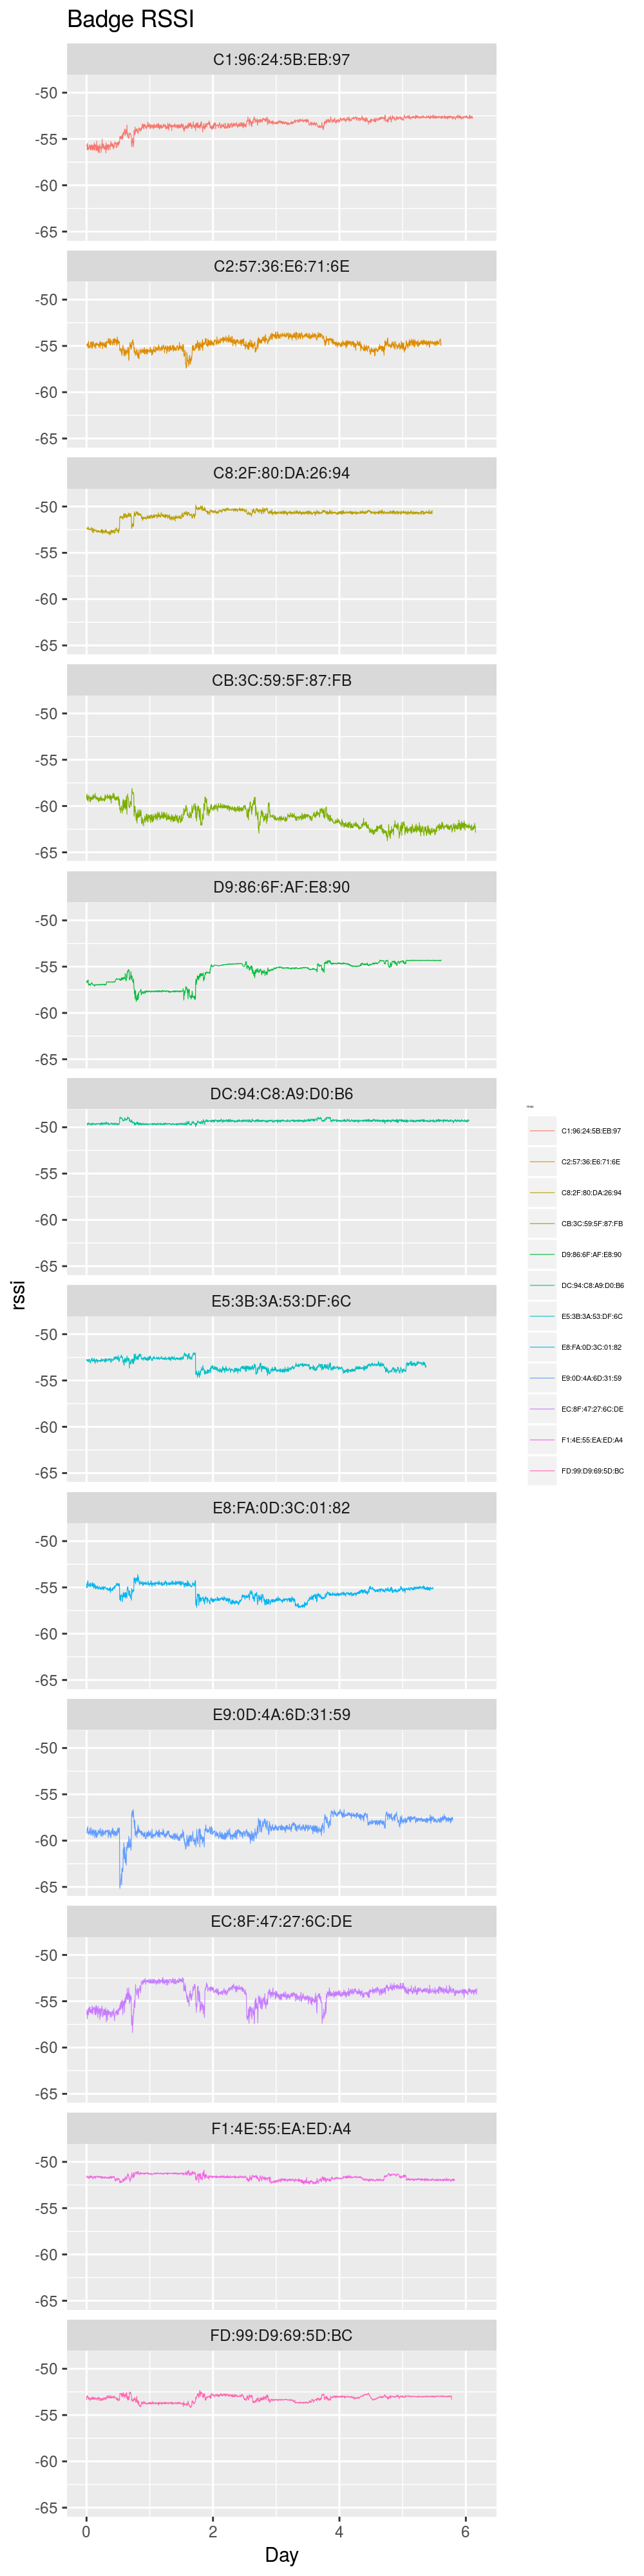

In [94]:
%%R -i rssi_scans_down -w 5 -h 20 --units in -r 200
data <- rssi_scans_down
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = rssi, color = mac)) +
    geom_line(size=0.2) +
    labs(title="Badge RSSI", x="Day", y="rssi") +
    facet_wrap( ~ mac, ncol=1)+
    rh_theme +
    theme(legend.text=element_text(size=4))
